In [1]:
using Plots
using ExaPF
using CUDA
using KernelAbstractions
import ExaPF: AutoDiff
const PS = ExaPF.PowerSystem
const LS = ExaPF.LinearSolvers

ExaPF.LinearSolvers

# Running a simple case

First, we select a local file that contains the case data in MATPOWER format. This file provides data for a power system network. The file contains information about buses, generators, transmission lines and their characteristics.

In [2]:
datafile = "case9.m"

"case9.m"

Then, we use the ExaPF.PolarForm function to create a PolarForm object that represents the power system in its polar form. The power system data is read from the MATPOWER file at the location specified by datafile. The second argument CPU() specifies that computations will be done on the CPU.

In [3]:
polar = ExaPF.PolarForm(datafile, CPU())  # Load data

Polar formulation (instantiated on device CPU(false))
Network characteristics:
    #buses:      9  (#slack: 1  #PV: 2  #PQ: 6)
    #generators: 3
    #lines:      9
giving a mathematical formulation with:
    #controls:   5
    #states  :   14

Where
- *buses*: Total number of bus nodes in the network, categorized into:
    - slack: Number of slack or reference buses.
    - PV: Number of PV (real power and voltage magnitude) buses.
    - PQ: Number of PQ (real and reactive power) buses.
- *generators*: Total number of generators in the network.
- *lines*: Total number of transmission lines in the network.
- *controls*: Number of control variables in the network. In a power system, control variables could be generator voltage, phase angle, etc.
- *states*: Number of state variables in the network. These are typically the variables we are interested in computing, such as bus voltage magnitudes and angles.

Let's examine the polar data structure via its getter functions

In [4]:
# Display the number of slack buses
nslack = get(polar, PS.NumberOfSlackBuses())
println("Number of slack buses: ", nslack)

# Display the number of PV buses
npv = get(polar, PS.NumberOfPVBuses())
println("Number of PV buses: ", npv)

# Display the number of generators
ngen = get(polar, PS.NumberOfGenerators())
println("Number of generators: ", ngen)

Number of slack buses: 1
Number of PV buses: 2
Number of generators: 3


The get function is used to fetch various network attributes from the PolarForm object, while the number function is used to get the count of various variables. In this example, we are fetching the number of slack buses, PV buses, generators, and control variables. All the information that the PolarForm encapsulate can be retrieved using the appropriate getters provided in the package, which makes it a convenient way of dealing with complex power network data.

The following line creates a NetworkStack object, which is essentially a data structure storing the different variables used in the power flow equations, namely voltage magnitudes, voltage angles, and power generations. The NetworkStack is initialized with the power system data represented in the polar object. 

In [5]:
stack = ExaPF.NetworkStack(polar)         # Load variables

21-elements NetworkStack{Vector{Float64}}

For instance, we can plot the generator power injection

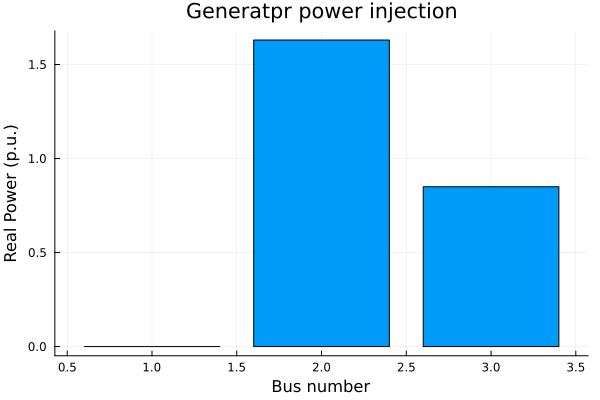

In [6]:
pgen = stack.pgen

# Create a bar plot
bar(pgen, title = "Generatpr power injection", xlabel = "Bus number", ylabel = "Real Power (p.u.)", legend = false)

The following is the core step of the power flow analysis. The function run_pf executes the power flow algorithm on the power system specified in polar, using the variables stored in stack. The keyword argument verbose=1 indicates that detailed output should be printed during the execution of the algorithm. The function returns a boolean value indicating whether the power flow analysis has converged or not.

In [7]:
convergence = run_pf(polar, stack; verbose=1)

#it 0: 2.64764e+00
#it 1: 2.03366e-01
#it 2: 2.94166e-03
#it 3: 8.85300e-07
#it 4: 7.89368e-14


Power flow has converged: true
  * #iterations: 4
  * Time Jacobian (s) ........: 0.6109
  * Time linear solver (s) ...: 0.0002
  * Time total (s) ...........: 1.1114


We can see how the residual norm of the equations decreases with each iteration until it reaches the default tolerance.

# Fine-grained control

In the following example, rather than directly creating a PolarObject, we first create a PowerNetwork object by parsing a MATPOWER data file specified by datafile. This object describes the physics and topology of the power system prior to specific mathematical formulation (polar or rectangular).

We then  create an object representing the basis of the power system equations in polar form, and then define a power flow model which combines the basis and the power balance equations.

The Jacobian matrix is evaluated using Automatic Differentiation (AD) and, for that, we need to initialize the sparse matrix data structure.

We set up the Newton-Raphson algorithm for solving the power flow problem. The parameters verbose=1 and tol=1e-6 specify that the algorithm will print its progress and use a convergence tolerance of 1e-6, respectively.

Finally, we solve the power flow equations using the configured Newton-Raphson algorithm and direct linear solver. The result is stored in convergence, which will indicate whether the algorithm successfully found a solution and met the convergence criteria.

This step-by-step process is a typical procedure for setting up and solving a power system optimization problem with the ExaPF.jl library. It makes use of several mathematical and numerical techniques, including polar representation of power system equations, automatic differentiation, and the Newton-Raphson method for nonlinear equation solving.

In [10]:
pf = PS.PowerNetwork(datafile)  # load the data to a PowerNetwork object

# Define the Polar Form
polar = ExaPF.PolarForm(pf, CPU())

# Define the Network Stack
stack = ExaPF.NetworkStack(polar)

# Define the basis and the power flow model
basis = ExaPF.PolarBasis(polar)
powerflow = ExaPF.PowerFlowBalance(polar) ∘ basis

# Evaluate the Jacobian using AutoDiff
mapx = ExaPF.mapping(polar, State());
jx = ExaPF.Jacobian(polar, powerflow, mapx)

# Instantiate a Direct Solver for the linear system
linear_solver = LS.DirectSolver(jx.J);

# Set up the Newton-Raphson algorithm
pf_algo = NewtonRaphson(; verbose=1, tol=1e-6)

# Solve the power flow equations
convergence = ExaPF.nlsolve!(pf_algo, jx, stack; linear_solver=linear_solver)

#it 0: 2.64764e+00
#it 1: 2.03366e-01
#it 2: 2.94166e-03
#it 3: 8.85300e-07


Power flow has converged: true
  * #iterations: 3
  * Time Jacobian (s) ........: 0.0001
  * Time linear solver (s) ...: 0.0002
  * Time total (s) ...........: 0.0004


# GPU computation

In [ ]:
# Define the Polar Form
polar_gpu = ExaPF.PolarForm(pf, CUDABackend())

# Define the Network Stack
stack_gpu = ExaPF.NetworkStack(polar_gpu)

# Define the basis and the power flow model
basis_gpu = ExaPF.PolarBasis(polar_gpu)
pflow_gpu = ExaPF.PowerFlowBalance(polar_gpu) ∘ basis_gpu

# Evaluate the Jacobian using AutoDiff
jx_gpu = ExaPF.Jacobian(polar_gpu, pflow_gpu, mapx)

# Instantiate a Direct Solver for the linear system
linear_solver = LS.DirectSolver(jx_gpu.J)

# Solve the power flow equations
convergence = ExaPF.nlsolve!(pf_algo, jx_gpu, stack_gpu; linear_solver=linear_solver)